# Пример распознавания автомобильных номеров

[Building a Captcha OCR in TF2.0](https://www.kaggle.com/aakashnain/building-a-captcha-ocr-in-tf2-0)

[Deep Learning OCR with Keras and Supervisely](https://hackernoon.com/latest-deep-learning-ocr-with-keras-and-supervisely-in-15-minutes-34aecd630ed8)

In [1]:
import cv2
import numpy as np
import tensorflow as tf

print(tf.__version__)

2.4.1


In [2]:
PLATE_NUM_LENGTH = 8

TEST_DATA_PATH = 'data/plate/test'
TRAIN_DATA_PATH = 'data/plate/train'

IMG_WIDTH = 128
IMG_HEIGHT = 64

POOL_NUM = 2
DOWNSAMPLE = POOL_NUM ** 2

## Загружаем алфавит

In [3]:
import os
import json
from collections import Counter
from glob import glob


def load_char_counts(path):
    """Загружаем словарь символов на основе данных разметки"""
    counts = Counter()
    for filename in glob(os.path.join(path, 'ann', '*.json')):
        with open(filename, 'r') as src:
            annotation = json.load(src)
        label = annotation['description']
        assert len(label) == PLATE_NUM_LENGTH
        counts.update(label)
    return counts

LETTERS = sorted(load_char_counts(TRAIN_DATA_PATH).keys())
print('Letters:', ' '.join(LETTERS))

Letters: 0 1 2 3 4 5 6 7 8 9 A B C E H K M O P T X Y


## Утилиты подготовки входных данных

In [4]:
import random
import functools

def indices_to_text(indicies, letters):
    """Возвращает текст для заданных индексов"""
    return ''.join(map(letters.__getitem__, indicies))

def text_to_indices(text, letters):
    """Конвертирует текст в список индексов"""
    return list(map(letters.index, text))

class DataGenerator:
    """Загрузка и подготвка данных для обучения/тестирования"""
    def __init__(self, 
                 path, 
                 img_width,
                 img_height, 
                 batch_size,
                 letters,
                 max_label_len):
        
        self._img_height = img_height
        self._img_width = img_width
        self._batch_size = batch_size
        self._letters = letters
        self._max_label_len = max_label_len
        
        self._files = []
        for img_path in glob(os.path.join(path, 'img', '*.png')):
            basename, _ = os.path.splitext(os.path.basename(img_path))
            annotation_path = os.path.join(path, 'ann', '%s.json' % basename)
            with open(annotation_path, 'r') as src:
                annotation = json.load(src)
                self._files.append((img_path, annotation['description']))
    
    @property
    def steps_per_epoch(self):
        return len(self._files) // self._batch_size
    
    @functools.lru_cache(maxsize=1024)
    def _load_img(self, path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self._img_width, self._img_height))
        img = np.float32(img) / 255.
        return img.reshape((self._img_height, self._img_width, 1))
    
    def __call__(self):
        while True:
            assert self.steps_per_epoch > 0
    
            batch_img = np.zeros(
                [self._batch_size, 
                 self._img_height, self._img_width, 1], np.float32)
            
            random.shuffle(self._files)
            for i in range(0, len(self._files), self._batch_size):
                k = i + self._batch_size
                if k > len(self._files):
                    break

                batch_labels = np.zeros([self._batch_size, 
                                         self._max_label_len], np.int32)
            
                batch_labels_length = np.zeros([self._batch_size, 1])
                
                for j, (img_path, label) in enumerate(self._files[i:k]):
                    batch_img[j] = self._load_img(img_path)
                    batch_labels[j] = text_to_indices(label, self._letters)
                    batch_labels_length[j] = len(label)
                                
                outputs = {
                    'labels': batch_labels,
                    'labels_length': batch_labels_length
                }

                yield batch_img, outputs

Text generator output (data which will be fed into the neutral network):
1) input (image) 64x128


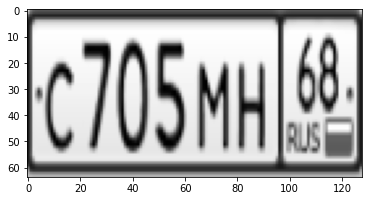

2) labels (plate number): C705MH68 is encoded as [12  7  0  5 16 14  6  8]
3) label_length (length of plate number): 8


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

data = DataGenerator(TRAIN_DATA_PATH,
                     batch_size=1,
                     img_width=128,
                     img_height=64,
                     letters=LETTERS,
                     max_label_len=PLATE_NUM_LENGTH)

x, y_true = next(data())
label_indices = y_true['labels'][0]
label = indices_to_text(label_indices, LETTERS)
label_length = y_true['labels_length'][0]

print('Text generator output (data which will be fed into the neutral network):')
print('1) input (image) %dx%d' % x[0].shape[:2])
plt.imshow(np.squeeze(x[0]), cmap='gray')
plt.show()

print('2) labels (plate number): %s is encoded as %s' % (label, label_indices))
print('3) label_length (length of plate number): %d' % label_length)

## Архитектура сети и функция потерь

In [6]:
from itertools import groupby
from tensorflow.keras import backend as K

class PlateOCR(tf.keras.Model):
    
    def __init__(self, input_shape,
                 num_classes, name='plate_ocr'):
        super(PlateOCR, self).__init__(name=name)
        
        img_height, img_width, img_channels = input_shape
        
        self._permute = tf.keras.layers.Permute(dims=(2, 1, 3),
                                                input_shape=input_shape,
                                                name='permute')
        
        self._conv1 = tf.keras.layers.Conv2D(16,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv_1')
        self._pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, name='pool_1')
        
        self._conv2 = tf.keras.layers.Conv2D(16,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv_2')
        self._pool2 = tf.keras.layers.MaxPooling2D(pool_size=2, name='pool_2')
        
        self._rnn_input_length = img_width
        self._rnn_input_length //= self._pool1.pool_size[0]
        self._rnn_input_length //= self._pool2.pool_size[0]
        
        self._rnn_input_features = img_height
        self._rnn_input_features //= self._pool1.pool_size[1]
        self._rnn_input_features //= self._pool2.pool_size[1]
        self._rnn_input_features *= self._conv2.filters
        
        self._reshape = tf.keras.layers.Reshape(
            target_shape=(self._rnn_input_length,
                          self._rnn_input_features),
            name='reshape')
        
        self._dense = tf.keras.layers.Dense(32, 
                                            activation='relu',
                                            name='dense_1')
        
        self._gru_1_fw = tf.keras.layers.GRU(512,
                                             return_sequences=True,
                                             name='gru_1_fw')
        self._gru_1_bw = tf.keras.layers.GRU(512,
                                             go_backwards=True,
                                             return_sequences=True,
                                             name='gru_1_bw')
        
        self._gru_2_fw = tf.keras.layers.GRU(512,
                                             return_sequences=True,
                                             name='gru_2_fw')
        self._gru_2_bw = tf.keras.layers.GRU(512,
                                             go_backwards=True,
                                             return_sequences=True,
                                             name='gru_2_bw')
        
        self._output = tf.keras.layers.Dense(num_classes + 1, 
                                             activation='softmax',
                                             name='output')
        
        self.build(input_shape=(None, img_height, img_width, img_channels))

    def call(self, x):
        x = self._conv1(self._permute(x))
        x = self._pool1(x)
        
        x = self._conv2(x)
        x = self._pool2(x)
        
        x = self._dense(self._reshape(x))
        
        x = tf.keras.layers.add([self._gru_1_fw(x),
                                 self._gru_1_bw(x)])
        
        x = tf.keras.layers.add([self._gru_2_fw(x),
                                 self._gru_2_bw(x)])
        
        return self._output(x)

    def train_step(self, data):
        x, y_true = data
        
        labels = y_true['labels']
        labels_length = y_true['labels_length']
        
        input_length = self._rnn_input_length * tf.ones_like(labels_length)
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = K.ctc_batch_cost(labels,
                                    y_pred,
                                    input_length,
                                    labels_length)

        gradients = tape.gradient(
            loss, self.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.trainable_variables))
        
        return {'loss': loss}
    
    def decode(self, y_pred, letters):
        result = []
        for prediction in y_pred:
            indices = [i for i, _ in groupby(np.argmax(prediction, -1))]
            indices = [i for i in indices if i < len(letters)]
            result.append(indices_to_text(indices, letters))
        return result

## Обучение модели

In [7]:
model = PlateOCR(num_classes=len(LETTERS),
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 1))

model.summary()

Model: "plate_ocr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            multiple                  0         
_________________________________________________________________
conv_1 (Conv2D)              multiple                  160       
_________________________________________________________________
pool_1 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
conv_2 (Conv2D)              multiple                  2320      
_________________________________________________________________
pool_2 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
reshape (Reshape)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  82

In [8]:
EPOCHS = 200
BATCH_SIZE = 8

data = DataGenerator(TRAIN_DATA_PATH,
                     img_width=IMG_WIDTH,
                     img_height=IMG_HEIGHT,
                     batch_size=BATCH_SIZE,
                     letters=LETTERS,
                     max_label_len=PLATE_NUM_LENGTH)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4))

In [ ]:
model.fit(data(),
          epochs=EPOCHS,
          steps_per_epoch=data.steps_per_epoch)

## Загружаем обученную ранее модель

In [10]:
model.load_weights('data/plate/plate-ocr.hdf5')

# Визуализация результата

Predicted: C733YH39
Expected: C736YH59


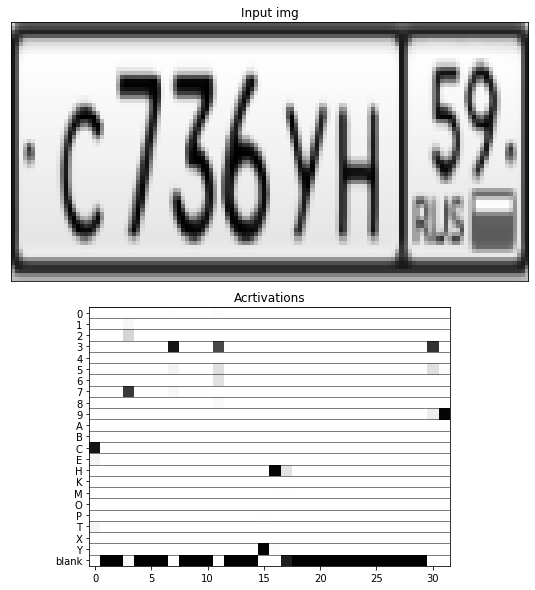

Predicted: K182EX8
Expected: A182EX78


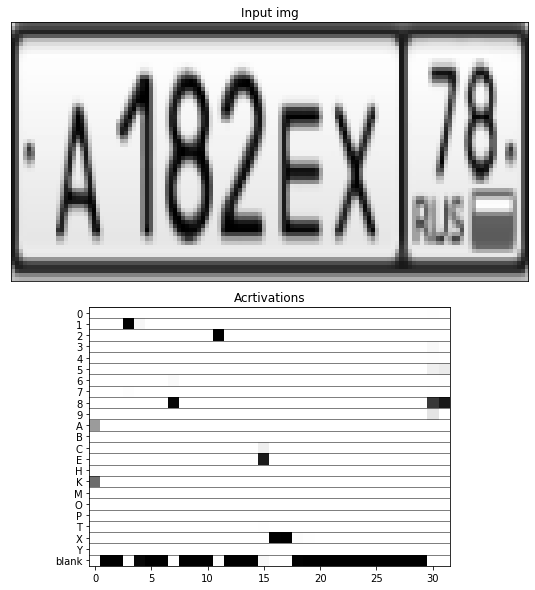

Predicted: X465HE15
Expected: H465HE18


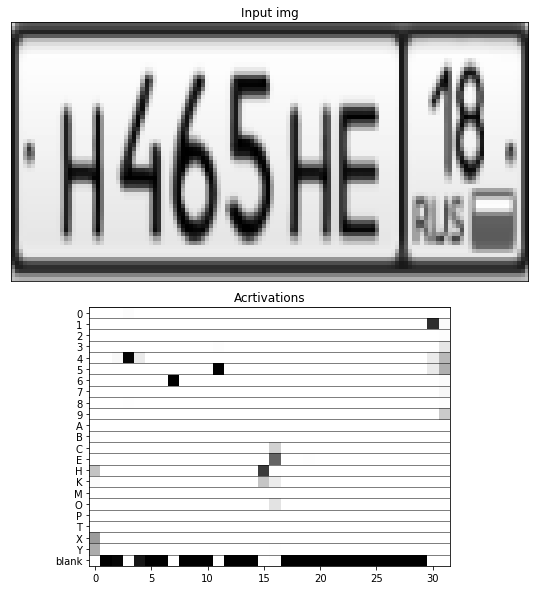

Predicted: Y853YT01
Expected: Y853XT81


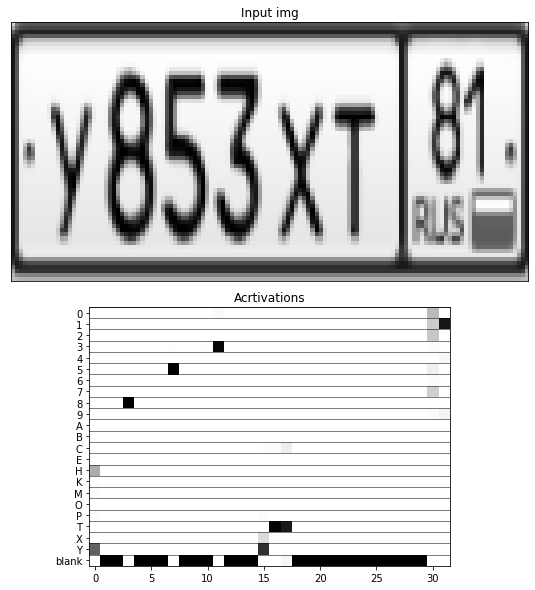

Predicted: X672EC21
Expected: X672EC01


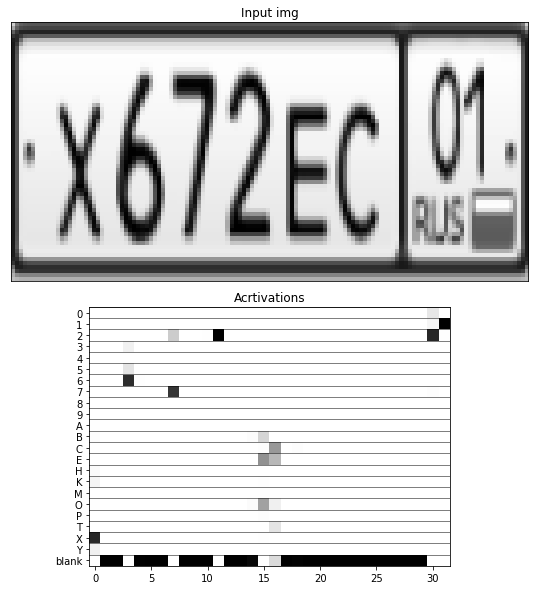

Predicted: O501OT1
Expected: O511OT51


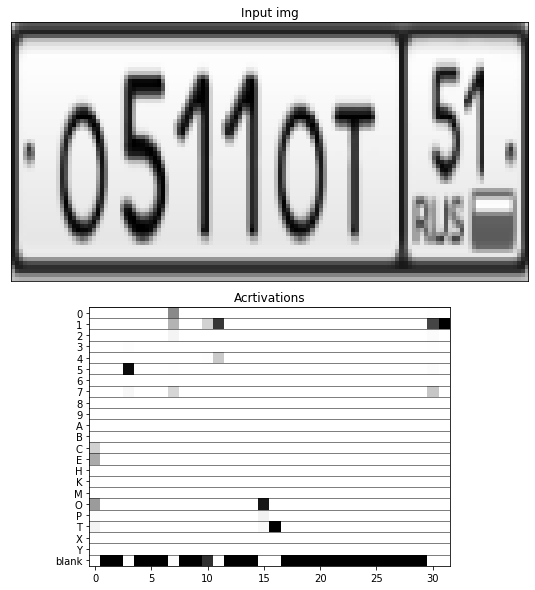

Predicted: B332PM21
Expected: B032BM01


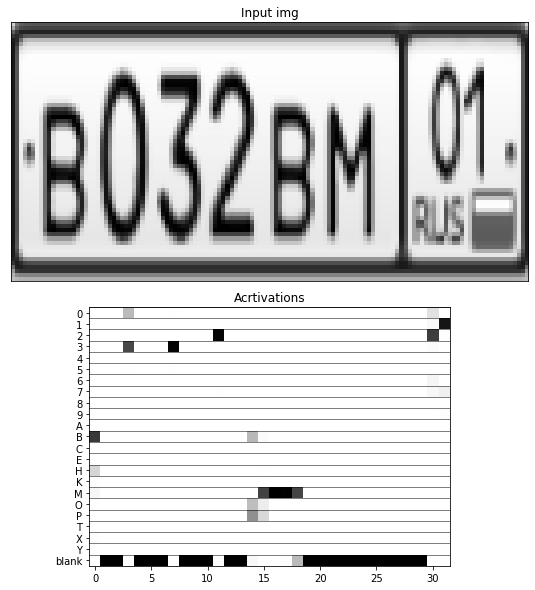

Predicted: O846M23
Expected: K846AM33


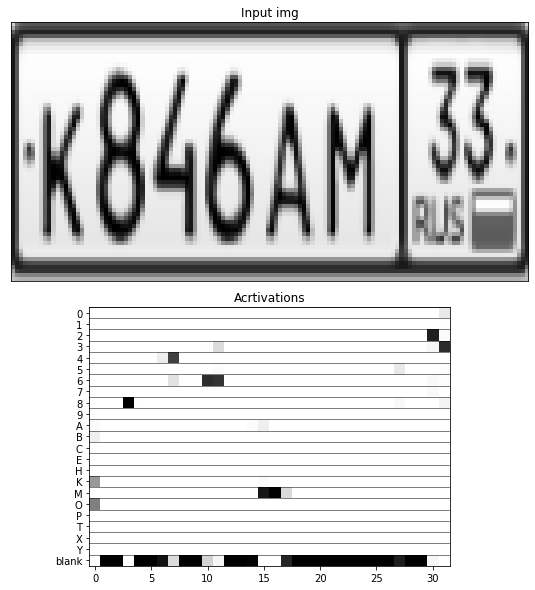

In [11]:
import matplotlib.gridspec as gridspec

TEST_BATCH_SIZE = 8

test_data = DataGenerator(TEST_DATA_PATH,
                          img_width=IMG_WIDTH,
                          img_height=IMG_HEIGHT,
                          batch_size=TEST_BATCH_SIZE,
                          letters=LETTERS,
                          max_label_len=PLATE_NUM_LENGTH)

for batch_img, y_true in test_data():
    y_pred = model.predict(batch_img)
    labels_pred = model.decode(y_pred, LETTERS)
    labels = [indices_to_text(i, LETTERS) for i in y_true['labels']]
    
    for i in range(TEST_BATCH_SIZE):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nExpected: %s' % (labels_pred[i], labels[i]))
        ax1.set_title('Input img')
        ax1.imshow(np.squeeze(batch_img[i]), cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Acrtivations')
        ax2.imshow(y_pred[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(LETTERS) + 1)))
        ax2.set_yticklabels(LETTERS + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(LETTERS) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        plt.show()
    break